# Pizza Prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Load Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

## EDA

The dataframe is clean (no null values).

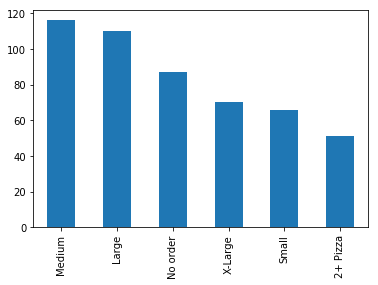

In [3]:
train['Size'].value_counts().plot(kind = 'bar')

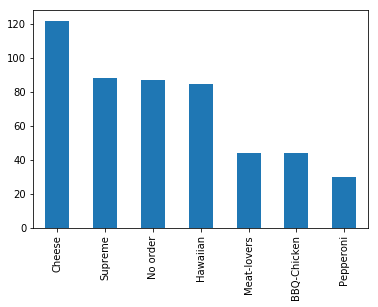

In [4]:
train['Toppings'].value_counts().plot(kind = 'bar')

{'boxes': [<matplotlib.lines.Line2D at 0x11a46f240>],
 'caps': [<matplotlib.lines.Line2D at 0x11a478c18>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a480e48>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a480630>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11a46fba8>,
  <matplotlib.lines.Line2D at 0x11a46fda0>]}

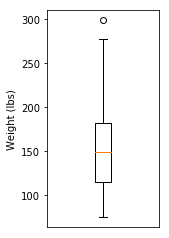

In [5]:
plt.figure(figsize = (2,4))
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.ylabel('Weight (lbs)')
plt.boxplot(train['Weight'])

{'boxes': [<matplotlib.lines.Line2D at 0x11a5c4908>],
 'caps': [<matplotlib.lines.Line2D at 0x11a5cec88>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a5ddba8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a5d5cf8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11a5c4ac8>,
  <matplotlib.lines.Line2D at 0x11a5ceac8>]}

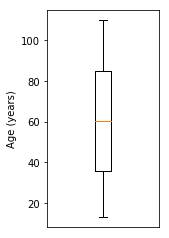

In [6]:
plt.figure(figsize = (2,4))
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.ylabel('Age (years)')
plt.boxplot(train['Age'])

{'boxes': [<matplotlib.lines.Line2D at 0x11a66bef0>],
 'caps': [<matplotlib.lines.Line2D at 0x11a67f908>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a685b38>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a685320>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11a677898>,
  <matplotlib.lines.Line2D at 0x11a677a90>]}

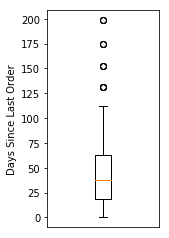

In [7]:
plt.figure(figsize = (2,4))
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.ylabel('Days Since Last Order')
plt.boxplot(train['Days'])

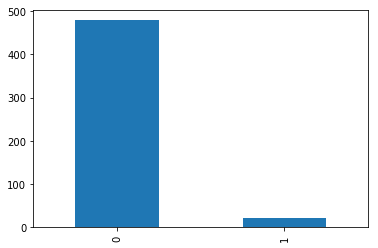

In [8]:
train['Vegan'].value_counts().plot(kind = 'bar')

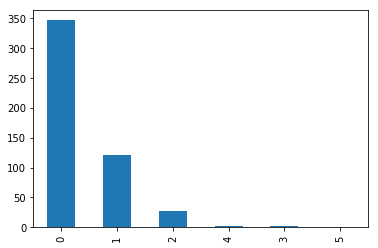

In [9]:
train['Cats'].value_counts().plot(kind = 'bar')

{'boxes': [<matplotlib.lines.Line2D at 0x11a8b5358>],
 'caps': [<matplotlib.lines.Line2D at 0x11a8bdd30>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a8c5f60>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a8c5748>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11a8b5cc0>,
  <matplotlib.lines.Line2D at 0x11a8b5eb8>]}

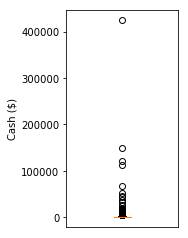

In [10]:
plt.figure(figsize = (2,4))
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.ylabel('Cash ($)')
plt.boxplot(train['Cash'])

## Baseline Accuracy

In [11]:
len(test_labels[test_labels['Size'] == 'Medium'])/len(test_labels)

0.18

In [12]:
len(test_labels[test_labels['Toppings'] == 'Cheese'])/len(test_labels)

0.25333333333333335

## Test/Train Split

In [13]:
np.random.seed(36)

train_index = np.random.choice(range(500), 375, replace = False)

train_df = train.iloc[train_index]
train_df.reset_index(inplace = True)

val_df = train.loc[set(train.index) - set(train_index)]
val_df.reset_index(inplace = True)

## Accuracy Metric

In [14]:
def accuracy(preds, labels):
    num_correct = 0
    for i in range(len(preds)):
        if preds[i] == labels[i]:
            num_correct += 1
    return num_correct/len(preds)

## Logistic Regression

### Parameters

In [16]:
penalty = ['l1', 'l2']
class_weight = [None, 'balanced']
multi_class = ['ovr', 'multinomial']

In [19]:
def lr_grid_search(target, penalty_list, class_weight_list, multi_class_list):
    best_accuracy = 0
    best_params = []
    for penalty in penalty_list:
        if penalty == 'l1':
            solver_list = ['liblinear', 'saga']
        if penalty == 'l2':
            solver_list = ['newton-cg', 'lbfgs', 'sag']
        for class_weight in class_weight_list:
            for multi_class in multi_class_list:
                for solver in solver_list:
                    if solver == 'liblinear' and multi_class == 'multinomial':
                        continue
                    lr = LogisticRegression(penalty = penalty, class_weight = class_weight, multi_class = multi_class, solver = solver)
                    lr.fit(train_df.drop(['Size', 'Toppings'], axis = 1), train_df[target])
                    lr_preds = lr.predict(val_df.drop(['Size', 'Toppings'], axis = 1))
                    lr_accuracy = accuracy(lr_preds, val_df[target])
                    if lr_accuracy > best_accuracy:
                        best_accuracy = lr_accuracy
                        best_params = [penalty, class_weight, multi_class, solver]
    return best_accuracy, best_params

### Size

In [20]:
acc, params = lr_grid_search('Size', penalty, class_weight, multi_class)

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [21]:
acc

0.432

In [22]:
params

['l2', 'balanced', 'ovr', 'lbfgs']

### Toppings

In [23]:
acc, params = lr_grid_search('Toppings', penalty, class_weight, multi_class)

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/utils/optimize

In [24]:
acc

0.536

In [25]:
params

['l1', None, 'ovr', 'liblinear']

## Random Forest

### Parameters

In [26]:
n_estimators = [1, 5, 10, 20, 50]
max_depth = [1, 3, 5, 10]
min_samples_leaf = [1, 3, 5, 10]
max_features = [0.1, 0.25, 0.5, 0.75, 1]
oob_score = [True, False]

In [31]:
def rf_grid_search(target, n_estimators_list, max_depth_list, min_samples_leaf_list, max_features_list, oob_score_list):
    best_accuracy = 0
    best_params = []
    for n in n_estimators_list:
        for max_depth in max_depth_list:
            for min_samples_leaf in min_samples_leaf_list:
                for max_features in max_features_list:
                    for oob_score in oob_score_list:
                        rf = RandomForestClassifier(n_estimators = n, max_depth = max_depth, min_samples_leaf = min_samples_leaf,
                                                   max_features = max_features, oob_score = oob_score)
                        rf.fit(train_df.drop(['Size', 'Toppings'], axis = 1), train_df[target])
                        rf_preds = rf.predict(val_df.drop(['Size', 'Toppings'], axis = 1))
                        rf_accuracy = accuracy(rf_preds, val_df[target])
                        if rf_accuracy > best_accuracy:
                            best_accuracy = rf_accuracy
                            best_params = [n, max_depth, min_samples_leaf, max_features, oob_score]
    return best_accuracy, best_params
                        

### Size

In [32]:
acc, params = rf_grid_search('Size', n_estimators, max_depth, min_samples_leaf, max_features, oob_score)

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

In [33]:
acc

0.504

In [34]:
params

[20, 5, 5, 0.75, True]

### Toppings

In [35]:
acc, params = rf_grid_search('Toppings', n_estimators, max_depth, min_samples_leaf, max_features, oob_score)

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sk

In [36]:
acc

0.544

In [37]:
params

[10, 3, 10, 0.75, True]

## XGBoost

### Label Encoding Categorical Response Variables

In [38]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(train['Size'])
label_encoded_size = label_encoder.transform(train['Size'])

In [39]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(train['Toppings'])
label_encoded_toppings = label_encoder.transform(train['Toppings'])

### Params

In [40]:
learning_rate = [0.01, 0.05, 0.1, 0.3, 0.5]
n_estimators = [1, 5, 10, 20, 50]
max_depth = [1, 3, 5, 10]
subsample = [0.1, 0.25, 0.5, 0.75, 1]

### Size

In [41]:
dtrain = xgb.DMatrix(train_df.drop(['Size', 'Toppings'], axis = 1), label = label_encoded_size)
dtest = xgb.DMatrix(val_df.drop(['Size', 'Toppings'], axis = 1))

In [42]:
def xgb_grid_search(target, learning_rate_list, n_estimators_list, max_depth_list, subsample_list):
    best_accuracy = 0
    best_params = []
    for learning_rate in learning_rate_list:
        for n in n_estimators_list:
            for max_depth in max_depth_list:
                for subsample in subsample_list:
                    xgb_model = xgb.sklearn.XGBClassifier(learning_rate=learning_rate, n_estimators=n, 
                                                          max_depth=max_depth, min_child_weight=1, 
                                                          gamma=0, subsample=subsample, colsample_bytree=0.8, 
                                                          objective='multi:softmax', nthread=4, scale_pos_weight=1,
                                                          seed=27) 
                    xgb_model.fit(train_df.drop(['Size', 'Toppings'], axis = 1), train_df[target])
                    xgb_preds = xgb_model.predict(val_df.drop(['Size', 'Toppings'], axis = 1))
                    xgb_accuracy = accuracy(xgb_preds, val_df[target])
                    if xgb_accuracy > best_accuracy:
                        best_accuracy = xgb_accuracy
                        best_params = [learning_rate, n, max_depth, subsample]
    return best_accuracy, best_params

In [43]:
acc, params = xgb_grid_search('Size', learning_rate, n_estimators, max_depth, subsample)

In [44]:
acc

0.488

In [45]:
params

[0.3, 20, 5, 0.75]

### Toppings

In [46]:
dtrain = xgb.DMatrix(train_df.drop(['Size', 'Toppings'], axis = 1), label = label_encoded_toppings)
dtest = xgb.DMatrix(val_df.drop(['Size', 'Toppings'], axis = 1))

In [47]:
acc, params = xgb_grid_search('Toppings', learning_rate, n_estimators, max_depth, subsample)

In [48]:
acc

0.544

In [49]:
params

[0.01, 5, 5, 0.75]

## Best Model

### Size

In [52]:
best_rf = RandomForestClassifier(n_estimators = 20, max_depth = 5, min_samples_leaf = 5,
                                                   max_features = 0.75, oob_score = True)
best_rf.fit(train.drop(['Size', 'Toppings'], axis = 1), train['Size'])
best_rf_preds = best_rf.predict(test)
best_rf_accuracy = accuracy(best_rf_preds, test_labels['Size'])

In [54]:
best_rf_accuracy

0.36

### Toppings

In [55]:
best_rf = RandomForestClassifier(n_estimators = 10, max_depth = 3, min_samples_leaf = 10,
                                                   max_features = 0.75, oob_score = True)
best_rf.fit(train.drop(['Size', 'Toppings'], axis = 1), train['Toppings'])
best_rf_preds = best_rf.predict(test)
best_rf_accuracy = accuracy(best_rf_preds, test_labels['Toppings'])

/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jtoffler/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [56]:
best_rf_accuracy

0.4